In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from netCDF4 import Dataset 
import xarray as xr
import matplotlib.pyplot as plt
from glob import glob
import os
import xarray as xr
from os.path import exists, join
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from hagelslag.evaluation import ContingencyTable, DistributedReliability
from mpl_toolkits.basemap import Basemap

In [2]:
dam_coords = (39.538889, -121.485556)

In [3]:
lme_month_dir = "/glade/p/cesm0005/CESM-CAM5-LME/atm/proc/tseries/monthly/"
lme_daily_dir = "/glade/p/cesm0005/CESM-CAM5-LME/atm/proc/tseries/daily/"
sorted(os.listdir(lme_month_dir + "*"))

['/glade/p/cesm0005/CESM-CAM5-LME/atm/proc/tseries/monthly/ABSORB',
 '/glade/p/cesm0005/CESM-CAM5-LME/atm/proc/tseries/monthly/AEROD_v',
 '/glade/p/cesm0005/CESM-CAM5-LME/atm/proc/tseries/monthly/ALBTOA',
 '/glade/p/cesm0005/CESM-CAM5-LME/atm/proc/tseries/monthly/ALBTOA..',
 '/glade/p/cesm0005/CESM-CAM5-LME/atm/proc/tseries/monthly/ALBTOAC',
 '/glade/p/cesm0005/CESM-CAM5-LME/atm/proc/tseries/monthly/ALBTOM',
 '/glade/p/cesm0005/CESM-CAM5-LME/atm/proc/tseries/monthly/ANRAIN',
 '/glade/p/cesm0005/CESM-CAM5-LME/atm/proc/tseries/monthly/ANSNOW',
 '/glade/p/cesm0005/CESM-CAM5-LME/atm/proc/tseries/monthly/AOA1',
 '/glade/p/cesm0005/CESM-CAM5-LME/atm/proc/tseries/monthly/AOA1SRC',
 '/glade/p/cesm0005/CESM-CAM5-LME/atm/proc/tseries/monthly/AOA2',
 '/glade/p/cesm0005/CESM-CAM5-LME/atm/proc/tseries/monthly/AOA2SRC',
 '/glade/p/cesm0005/CESM-CAM5-LME/atm/proc/tseries/monthly/AODABS',
 '/glade/p/cesm0005/CESM-CAM5-LME/atm/proc/tseries/monthly/AODDUST1',
 '/glade/p/cesm0005/CESM-CAM5-LME/atm/proc/t

In [4]:
nc_file = join(lme_daily_dir, "PRECT", "b.e11.BLMTRC5CN.f19_g16.002.cam.h1.PRECT.08500101-18491231.nc")
ds = xr.open_dataset(nc_file, )

/glade/p/work/dgagne/miniconda/envs/hail/lib/python3.5/site-packages/xarray/conventions.py:393: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/glade/p/work/dgagne/miniconda/envs/hail/lib/python3.5/site-packages/xarray/conventions.py:412: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


In [48]:
ds_2 = xr.Dataset(data_vars={"PRECT": ds["PRECT"][valid_months]}, coords={"lon":ds["lon"], "lat":ds["lat"], "date":ds["date"]})


In [49]:
ds_2

<xarray.Dataset>
Dimensions:  (lat: 96, lon: 144, time: 365000)
Coordinates:
  * time     (time) object  850-01-01 00:00:00  850-01-02 00:00:00 ...
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 -82.42 -80.53 -78.63 ...
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 12.5 15.0 17.5 20.0 22.5 ...
    date     (time) int32 8500101 8500102 8500103 8500104 8500105 8500106 ...
Data variables:
    PRECT    (time, lat, lon) float32 nan nan nan nan nan nan nan nan nan ...

In [4]:
nc_file = join(lme_daily_dir, "PRECT", "b.e11.BLMTRC5CN.f19_g16.002.cam.h1.PRECT.08500101-18491231.nc")
d = Dataset(nc_file)

In [6]:
d.variables["PRECT"].shape

(365000, 96, 144)

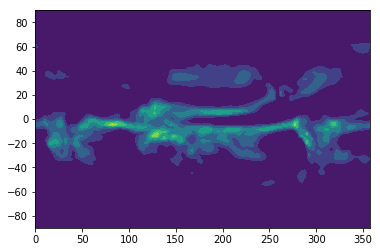

In [62]:
plt.contourf(d.variables["lon"][:], d.variables["lat"][:], d.variables["PRECC"][25])

In [5]:
lats = d.variables["lat"][:]
lons = d.variables["lon"][:]

In [6]:
np.argmin(np.abs(dam_coords[0] - lats)), np.argmin(np.abs(dam_coords[1] + 360 - lons))



(68, 95)

In [14]:
lats[68], lons[95] - 360

(38.84210526315789, -122.5)

In [43]:
all_dates = d.variables["date"][:]

In [44]:
all_dates_str = pd.Series(all_dates.astype("U8"))
all_days = all_dates_str.str[-2:].astype(int)
all_months = all_dates_str.str[-4:-2].astype(int)
all_years = all_dates_str.str[:-4].astype(int)

In [46]:
dec_years = all_years[:]
dec_years[all_months == 12] += 1

In [47]:
valid_months = np.where(np.in1d(all_months.values, [12, 1, 2]) & (dec_years > 850) & (dec_years < 1850))[0]

In [11]:
prec = d.variables["PRECT"][valid_months, 68, 95]

In [12]:
daily_precip = pd.DataFrame({"month": all_months[valid_months],
                             "year": dec_years[valid_months],
                             "day": all_days[valid_months],
                             "precip": prec * 86400 * 1000}, columns=["year", "month", "day", "precip"])

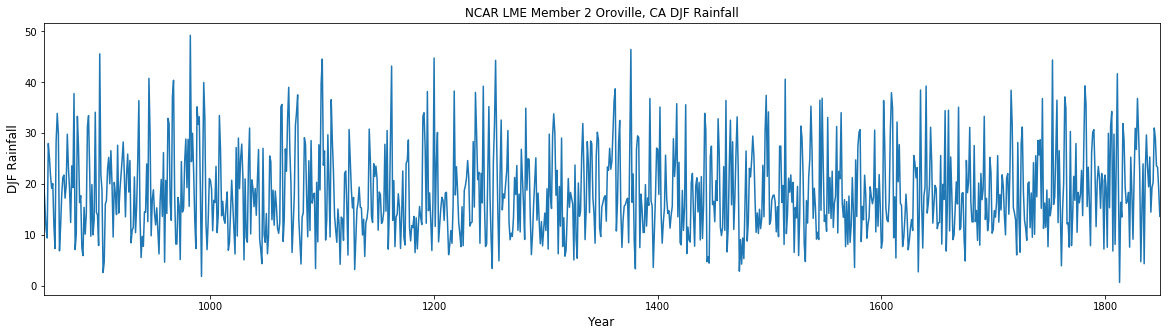

In [13]:
plt.figure(figsize=(20, 5))
winter_precip = daily_precip.groupby(["year"])["precip"].sum()
(winter_precip / 25.4).plot()
plt.xlabel("Year", fontsize=12)
plt.ylabel("DJF Rainfall", fontsize=12)
plt.title("NCAR LME Member 2 Oroville, CA DJF Rainfall")

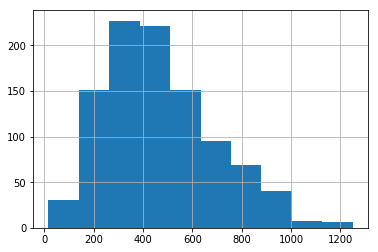

In [37]:
winter_precip.hist()

In [52]:
psl_file = join(lme_month_dir, "PSL", "b.e11.BLMTRC5CN.f19_g16.002.cam.h0.PSL.085001-184912.nc")
psl_file_2 = join(lme_month_dir, "PSL", "b.e11.BLMTRC5CN.f19_g16.002.cam.h0.PSL.185001-200512.nc")
ps_1 = xr.open_dataset(psl_file)
ps_2 = xr.open_dataset(psl_file_2)
#ps_ds = Dataset(psl_file)

/glade/p/work/dgagne/miniconda/envs/hail/lib/python3.5/site-packages/xarray/conventions.py:393: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/glade/p/work/dgagne/miniconda/envs/hail/lib/python3.5/site-packages/xarray/conventions.py:412: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


In [70]:
all_dates = xr.concat([ps_1["date"], ps_2["date"]], dim="time")
all_dates_str = pd.Series(all_dates.astype("U8"))

In [71]:
all_dates_str[::]

0         8500201
1         8500301
2         8500401
3         8500501
4         8500601
5         8500701
6         8500801
7         8500901
8         8501001
9         8501101
10        8501201
11        8510101
12        8510201
13        8510301
14        8510401
15        8510501
16        8510601
17        8510701
18        8510801
19        8510901
20        8511001
21        8511101
22        8511201
23        8520101
24        8520201
25        8520301
26        8520401
27        8520501
28        8520601
29        8520701
           ...   
13842    20030801
13843    20030901
13844    20031001
13845    20031101
13846    20031201
13847    20040101
13848    20040201
13849    20040301
13850    20040401
13851    20040501
13852    20040601
13853    20040701
13854    20040801
13855    20040901
13856    20041001
13857    20041101
13858    20041201
13859    20050101
13860    20050201
13861    20050301
13862    20050401
13863    20050501
13864    20050601
13865    20050701
13866    2

In [57]:
out = xr.concat([ps_1["PSL"], ps_2["PSL"]], dim="time")

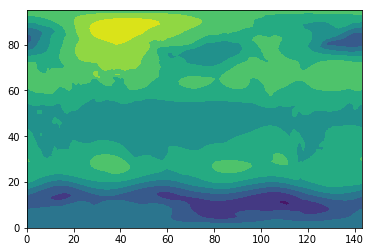

In [63]:
plt.contourf(out[-1])

In [15]:
ps_dates = pd.Series(ps_ds.variables["date"][:].astype("U8"))
ps_months = ps_dates.str[-4:-2]
nov_months = np.where(ps_months == "11")[0]
ps_fields = ps_ds.variables["PSL"][nov_months]

In [21]:
ps_norm_fields = (ps_fields - ps_fields.mean()) / ps_fields.std()

In [24]:
ps_pca = PCA(n_components=10)
ps_pca_fields = ps_pca.fit_transform(ps_norm_fields.reshape(-1, 96 * 144))

In [30]:
precip_norm = np.where(winter_precip >= winter_precip.mean(), 1, 0)

In [145]:
train_X, test_X, train_y, test_y = train_test_split(ps_pca_fields[:-1], precip_norm, train_size=0.7)

In [ ]:
ps_norm_fields.shape[-1]

In [146]:
lm = LogisticRegression()
lm.fit(train_X, train_y)
preds = lm.predict(test_X)
prob_preds = lm.predict_proba(test_X)[:, 1]

In [147]:
tp = np.count_nonzero((preds == test_y) & (test_y == 1))
fp = np.count_nonzero((preds != test_y) & (test_y == 0))
fn = np.count_nonzero((preds != test_y) & (test_y == 1))
tn = np.count_nonzero((preds == test_y) & (test_y == 0))
ct = ContingencyTable(tp, fp, fn, tn)

In [148]:
print(ct)

	Event
	Yes	No
Yes	55	37
No	72	136



In [149]:
dr = DistributedReliability(thresholds=np.arange(0, 1.1, 0.1))
dr.update(prob_preds, test_y)

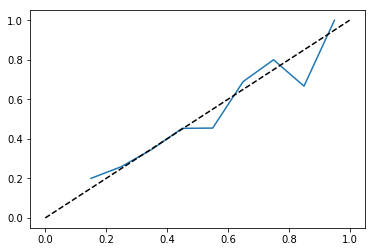

In [150]:
rel = dr.reliability_curve()
plt.plot(rel["Bin_Center"], rel["Positive_Relative_Freq"])
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k--')

In [151]:
dr.brier_score()

0.2234

In [152]:
np.mean((prob_preds - test_y) ** 2)

0.22009528318970425

(array([  0.,  20.,  51.,  75.,  64.,  44.,  27.,  12.,   6.,   1.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

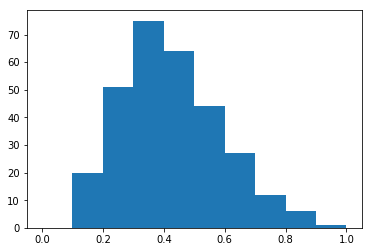

In [77]:
plt.hist(prob_preds, bins=np.arange(0, 1.1, 0.1))

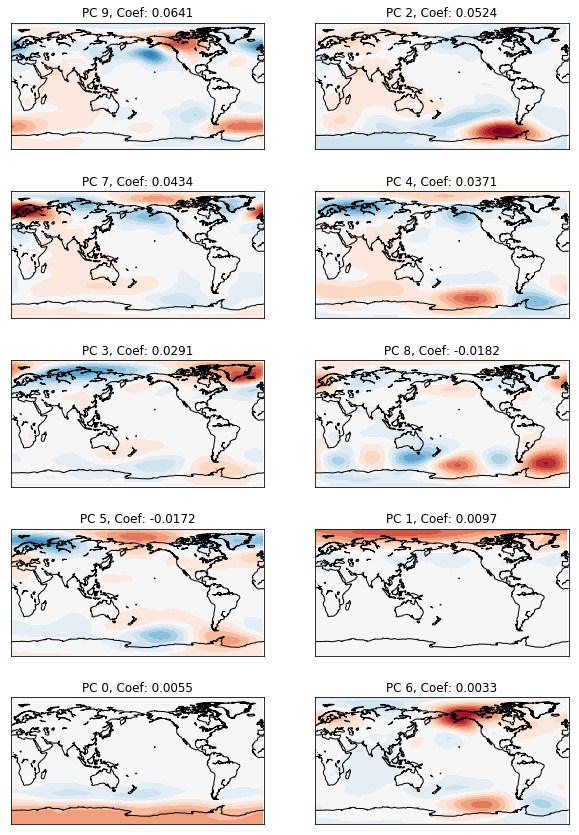

In [153]:
extent = np.max(np.abs([ps_pca.components_.max(), ps_pca.components_.min()]))
bmap = Basemap(projection="cyl", lon_0=180, llcrnrlon=0, urcrnrlon=360)
fig, axes = plt.subplots(5, 2, figsize=(10, 15))
a = 0
important_patterns = np.abs(lm.coef_[0]).argsort()[::-1]
for (r, c), ax in np.ndenumerate(axes):
    bmap.drawcoastlines(ax=ax)
    ax.contourf(lons, lats, ps_pca.components_[important_patterns[a]].reshape(ps_fields.shape[1:]), 
                np.linspace(-extent, extent, 20), cmap="RdBu_r")
    ax.set_title("PC {0:d}, Coef: {1:0.4f}".format(important_patterns[a], lm.coef_[0][important_patterns[a]]))
    a += 1

In [135]:
ps_pca.components_.shape

(10, 13824)

In [137]:
important_patterns

array([[1, 5, 0, 6, 8, 3, 7, 4, 2, 9]])

In [ ]:
lr = LinearRegression()
lr.fit()

In [158]:
def varimax(Phi, gamma = 1, q = 20, tol = 1e-6):
    from numpy import eye, asarray, dot, sum, diag
    from numpy.linalg import svd
    p,k = Phi.shape
    R = eye(k)
    d=0
    for i in range(q):
        d_old = d
        Lambda = dot(Phi, R)
        u,s,vh = svd(dot(Phi.T,asarray(Lambda)**3 - (gamma/p) * dot(Lambda, diag(diag(dot(Lambda.T,Lambda))))))
        R = dot(u,vh)
        d = sum(s)
        if d/d_old < tol: break
    return dot(Phi, R)

In [ ]:
varimax(ps_pca.components_)

In [ ]:
ps_pca.components

In [73]:
q = xr.open_dataset("/glade/p/cesm0005/CESM-CAM5-LME/atm/proc/tseries/monthly/Q/b.e11.BLMTRC5CN.f19_g16.001.cam.h0.Q.185001-200512.nc")
p = xr.open_dataset("/glade/p/cesm0005/CESM-CAM5-LME/atm/proc/tseries/monthly/PS/b.e11.BLMTRC5CN.f19_g16.001.cam.h0.PS.185001-200512.nc")


In [18]:
list(q.variables.keys())

['lev',
 'hyam',
 'hybm',
 'ilev',
 'hyai',
 'hybi',
 'P0',
 'time',
 'date',
 'datesec',
 'lat',
 'lon',
 'slat',
 'slon',
 'w_stag',
 'time_bnds',
 'date_written',
 'time_written',
 'ntrm',
 'ntrn',
 'ntrk',
 'ndbase',
 'nsbase',
 'nbdate',
 'nbsec',
 'mdt',
 'nlon',
 'wnummax',
 'gw',
 'ndcur',
 'nscur',
 'co2vmr',
 'ch4vmr',
 'n2ovmr',
 'f11vmr',
 'f12vmr',
 'sol_tsi',
 'nsteph',
 'Q']

In [75]:
p["PS"][0, 50, 50]

<xarray.DataArray 'PS' ()>
array(99792.3984375, dtype=float32)
Coordinates:
    time     datetime64[ns] 1850-02-01
    lat      float64 4.737
    lon      float64 125.0
Attributes:
    units:         Pa
    long_name:     Surface pressure
    cell_methods:  time: mean

In [35]:
q["ilev"]

<xarray.DataArray 'ilev' (ilev: 31)>
array([    2.25524 ,     5.031692,    10.157947,    18.555317,    30.669123,
          45.867477,    63.323483,    80.701418,    94.941042,   111.693211,
         131.401271,   154.586807,   181.863353,   213.952821,   251.704417,
         296.117216,   348.366588,   409.835219,   482.149929,   567.224421,
         652.332969,   730.445892,   796.363071,   845.353667,   873.715866,
         900.324631,   924.964462,   947.432335,   967.538625,   985.11219 ,
        1000.      ])
Coordinates:
  * ilev     (ilev) float64 2.255 5.032 10.16 18.56 30.67 45.87 63.32 80.7 ...
Attributes:
    long_name:      hybrid level at interfaces (1000*(A+B))
    units:          level
    positive:       down
    standard_name:  atmosphere_hybrid_sigma_pressure_coordinate
    formula_terms:  a: hyai b: hybi p0: P0 ps: PS

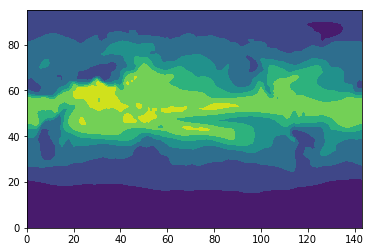

In [66]:
plt.contourf(q["Q"][30].sum(axis=0))

In [88]:
lev_diff = pres_levels[1:].values - pres_levels[0:-1].values

In [92]:
pres_levels[1:]

<xarray.DataArray (ilev: 30)>
array([   503.169186,   1015.794743,   1855.531707,   3066.912293,
         4586.747661,   6332.348287,   8070.141822,   9494.104236,
        11169.32109 ,  13140.127063,  15458.680689,  18186.335266,
        21387.111951,  25152.659863,  29582.632077,  34794.266352,
        40925.479259,  48138.538548,  56624.327369,  65113.513183,
        72904.91754 ,  79479.852621,  84366.438997,  87195.437821,
        89849.539621,  92307.249297,  94548.316088,  96553.825932,
        98306.708195,  99792.398438])
Coordinates:
  * ilev     (ilev) float64 5.032 10.16 18.56 30.67 45.87 63.32 80.7 94.94 ...
    time     datetime64[ns] 1850-02-01
    lat      float64 4.737
    lon      float64 125.0

In [94]:
np.sum(q["Q"][0, :, 50, 50] * lev_diff / 9.81 / 1000) * 1000

<xarray.DataArray 'Q' ()>
array(53.18240984278005)
Coordinates:
    time     datetime64[ns] 1850-02-01
    lat      float64 4.737
    lon      float64 125.0

In [76]:
q["ilev"]

<xarray.DataArray 'ilev' (ilev: 31)>
array([    2.25524 ,     5.031692,    10.157947,    18.555317,    30.669123,
          45.867477,    63.323483,    80.701418,    94.941042,   111.693211,
         131.401271,   154.586807,   181.863353,   213.952821,   251.704417,
         296.117216,   348.366588,   409.835219,   482.149929,   567.224421,
         652.332969,   730.445892,   796.363071,   845.353667,   873.715866,
         900.324631,   924.964462,   947.432335,   967.538625,   985.11219 ,
        1000.      ])
Coordinates:
  * ilev     (ilev) float64 2.255 5.032 10.16 18.56 30.67 45.87 63.32 80.7 ...
Attributes:
    long_name:      hybrid level at interfaces (1000*(A+B))
    units:          level
    positive:       down
    standard_name:  atmosphere_hybrid_sigma_pressure_coordinate
    formula_terms:  a: hyai b: hybi p0: P0 ps: PS

In [78]:
q["P0"]

<xarray.DataArray 'P0' ()>
array(100000.0)
Attributes:
    long_name:  reference pressure
    units:      Pa

In [86]:
pres_levels = q["P0"] * q["hyai"] + p["PS"][0, 50, 50] * q["hybi"]

In [95]:
pres_levels

<xarray.DataArray (ilev: 31)>
array([   225.523952,    503.169186,   1015.794743,   1855.531707,
         3066.912293,   4586.747661,   6332.348287,   8070.141822,
         9494.104236,  11169.32109 ,  13140.127063,  15458.680689,
        18186.335266,  21387.111951,  25152.659863,  29582.632077,
        34794.266352,  40925.479259,  48138.538548,  56624.327369,
        65113.513183,  72904.91754 ,  79479.852621,  84366.438997,
        87195.437821,  89849.539621,  92307.249297,  94548.316088,
        96553.825932,  98306.708195,  99792.398438])
Coordinates:
  * ilev     (ilev) float64 2.255 5.032 10.16 18.56 30.67 45.87 63.32 80.7 ...
    time     datetime64[ns] 1850-02-01
    lat      float64 4.737
    lon      float64 125.0